## Resources
- https://colab.research.google.com/drive/1F6Rc9I87YWzxBiznUSvH0AyqZNZpn2NQ

In [119]:
import pandas as pd
from sklearn.metrics import mean_absolute_error
import numpy as np
from statistics import mode
import re
from pycaret.classification import *

# Read the data
X = pd.read_csv('data/train.csv')
X_test_full = pd.read_csv('data/test.csv')

In [120]:
full = pd.concat([X, X_test_full])
full.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [121]:
# mode is the value which appears the most often, it's S for embarked
# mode(full["Embarked"]) # => 'S'
full["Embarked"] = full["Embarked"].fillna(mode(full["Embarked"]))

In [122]:
 # fill missing cabins with new U type
full['Cabin'] = full['Cabin'].fillna('U')

In [123]:
# the first letters of the cabins seem to be referring to a specific part of the boat
# keep only the initials in the Cabin column
full['Cabin'] = full['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())

In [124]:
# in age column Pclass has the highest correlation, so we use that to fill missing values
full['Age'] = full.groupby("Pclass")['Age'].transform(lambda x: x.fillna(x.median()))

In [125]:
# in Fare column Pclass has the highest correlation, so we use that to fill missing values
full['Fare'] = full.groupby("Pclass")['Fare'].transform(lambda x: x.fillna(x.median()))

In [126]:
# get a unique list of Initials from Cabin types
full['Cabin'].unique().tolist()

['U', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T']

In [127]:
# Extract the salutation! A few letters with a . in the end
full['Title'] = full.Name.str.extract(' ([A-Za-z]+)\.', expand = False)
full['Title'].unique().tolist()

['Mr',
 'Mrs',
 'Miss',
 'Master',
 'Don',
 'Rev',
 'Dr',
 'Mme',
 'Ms',
 'Major',
 'Lady',
 'Sir',
 'Mlle',
 'Col',
 'Capt',
 'Countess',
 'Jonkheer',
 'Dona']

In [128]:
# Sibsp is the number of siblings / spouses aboard
# Parch is the number of parents / children aboard
# So we calculate the family size
full['familySize'] = full['SibSp'] + full['Parch'] + 1

In [129]:
# Drop redundant features
full = full.drop(['Name', 'SibSp', 'Parch', 'Ticket'], axis = 1)

In [130]:
# One hot encoded
full_ohe = pd.get_dummies(full)



In [131]:
# recover the original test and train dataset
train = full_ohe[full_ohe['Survived'].notna()]
test = full_ohe[full_ohe['Survived'].isna()].drop(['Survived'], axis = 1)

In [132]:
# convert Survived values from float to int, it became float when concatenating
train.loc[:,'Survived'] = train.loc[:,'Survived'].astype(np.int8)

In [133]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Age', 'Fare', 'familySize',
       'Sex_female', 'Sex_male', 'Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D',
       'Cabin_E', 'Cabin_F', 'Cabin_G', 'Cabin_T', 'Cabin_U', 'Embarked_C',
       'Embarked_Q', 'Embarked_S', 'Title_Capt', 'Title_Col', 'Title_Countess',
       'Title_Don', 'Title_Dona', 'Title_Dr', 'Title_Jonkheer', 'Title_Lady',
       'Title_Major', 'Title_Master', 'Title_Miss', 'Title_Mlle', 'Title_Mme',
       'Title_Mr', 'Title_Mrs', 'Title_Ms', 'Title_Rev', 'Title_Sir'],
      dtype='object')

In [ ]:
# create transformation pipeline
titanicSetup = setup(train, target = 'Survived', session_id = 123,
           normalize = True,
           polynomial_features = True,
           trigonometry_features = True,
           feature_interaction=True,
           bin_numeric_features= ['Age'],
           ignore_features=['PassengerId'],
          categorical_features=['Pclass'],
          numeric_features=['familySize']
          )

IntProgress(value=0, description='Processing: ', max=13)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,12:33:05
Status,. . . . . . . . . . . . . . . . . .,Preparing Data for Modeling
ETC,. . . . . . . . . . . . . . . . . .,Calculating ETC


Text(value="Following data types have been inferred automatically, if they are correct press enter to continue…

,Data Type
Survived,Label
Pclass,Categorical
Age,Numeric
Fare,Numeric
familySize,Numeric
Sex_female,
Sex_male,
Cabin_A,
Cabin_B,
Cabin_C,


In [101]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,CatBoost Classifier,0.844200,0.868700,0.769700,0.817200,0.791000,0.667100
1,Gradient Boosting Classifier,0.841000,0.857000,0.753100,0.823000,0.782900,0.658300
2,Extreme Gradient Boosting,0.836200,0.867700,0.731900,0.824500,0.770900,0.644900
3,Ada Boost Classifier,0.831300,0.854100,0.740200,0.809800,0.768800,0.637000
4,Light Gradient Boosting Machine,0.825100,0.857700,0.753100,0.789500,0.767300,0.627800
5,Logistic Regression,0.825000,0.857100,0.728100,0.799600,0.759000,0.622700
6,Extra Trees Classifier,0.817100,0.842500,0.752900,0.768700,0.758600,0.611600
7,Linear Discriminant Analysis,0.817000,0.841300,0.707100,0.791700,0.744100,0.603200
8,Ridge Classifier,0.808900,0.000000,0.685900,0.788200,0.729900,0.584100
9,Random Forest Classifier,0.807400,0.842500,0.706500,0.776200,0.736900,0.585800


In [102]:
# Gradient Boosting Classifier is the most accurate model so we'll use this
my_model = create_model('catboost')

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.8571,0.8638,0.7917,0.8261,0.8085,0.6947
1,0.8571,0.8397,0.8333,0.8000,0.8163,0.6995
2,0.8730,0.9081,0.7917,0.8636,0.8261,0.7264
3,0.8710,0.9019,0.7391,0.8947,0.8095,0.7133
4,0.7742,0.7697,0.6250,0.7500,0.6818,0.5090
5,0.8065,0.8531,0.7083,0.7727,0.7391,0.5857
6,0.9355,0.8958,0.8750,0.9545,0.9130,0.8619
7,0.8226,0.8344,0.7083,0.8095,0.7556,0.6173
8,0.8226,0.8882,0.7917,0.7600,0.7755,0.6289
9,0.8226,0.9320,0.8333,0.7407,0.7843,0.6345


In [116]:
# tuned_model = tune_model('catboost', ensemble=True, method='Bagging')
tuned_model = tune_model('catboost')

IntProgress(value=0, description='Processing: ', max=16)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,12:33:05
Status,. . . . . . . . . . . . . . . . . .,Preparing Data for Modeling
ETC,. . . . . . . . . . . . . . . . . .,Calculating ETC


,Accuracy,AUC,Recall,Prec.,F1,Kappa


KeyboardInterrupt: 

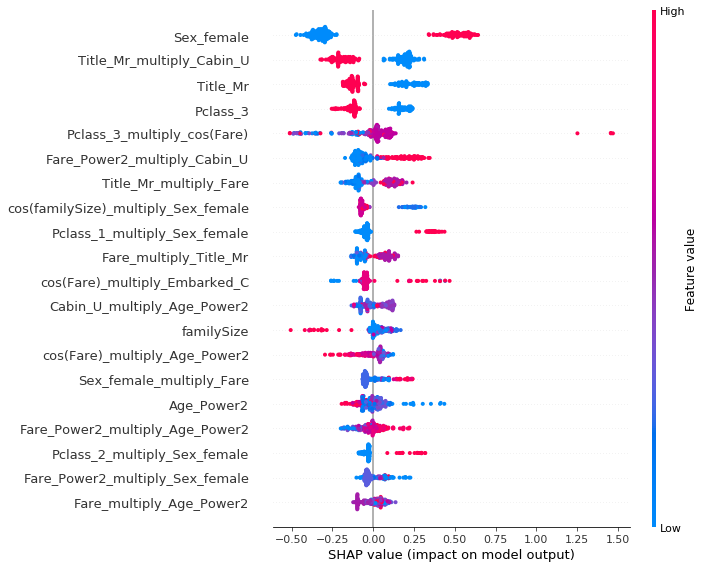

In [104]:
interpret_model(tuned_model, plot = 'summary')

In [105]:
predict_model(tuned_model);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,CatBoost Classifier,0.8134,0.8838,0.6796,0.8046,0.7368,0.5939


In [106]:
# Finalize Model: returns a model that has been trained on the entire dataset. 
titanic_final_model = finalize_model(tuned_model)

In [117]:
# Show the parameters used for final model
titanic_final_model.get_params()

{'iterations': 100,
 'learning_rate': 0.2,
 'depth': 6,
 'l2_leaf_reg': 100,
 'border_count': 50,
 'silent': True,
 'random_state': 123}

In [108]:
# make prediction with tuned model on full dataset
predict_model(titanic_final_model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,CatBoost Classifier,0.8918,0.9499,0.8155,0.8936,0.8528,0.7675


,Fare,familySize,Sex_female,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U,Embarked_C,Embarked_Q,Embarked_S,Title_Capt,Title_Col,Title_Countess,Title_Don,Title_Dona,Title_Dr,Title_Jonkheer,Title_Lady,Title_Major,Title_Master,Title_Miss,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rev,Title_Sir,Age_Power2,cos(familySize),cos(Fare),Fare_Power2,Pclass_1,Pclass_2,Pclass_3,SibSp_0,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Age_0.0,Age_1.0,Age_10.0,Age_2.0,Age_3.0,Age_4.0,Age_5.0,Age_6.0,Age_7.0,Age_8.0,Age_9.0,cos(familySize)_multiply_Sex_female,Title_Miss_multiply_cos(familySize),Title_Mr_multiply_Fare,Sex_female_multiply_Fare,Age_Power2_multiply_Fare,Parch_0_multiply_Sex_female,Age_Power2_multiply_Fare_Power2,Age_Power2_multiply_cos(familySize),Pclass_2_multiply_Sex_female,Fare_multiply_Embarked_S,Cabin_U_multiply_Age_Power2,Embarked_S_multiply_Sex_female,Title_Mr_multiply_Embarked_S,Fare_multiply_cos(familySize),Embarked_S_multiply_Title_Mr,Pclass_3_multiply_Title_Mr,Age_6.0_multiply_cos(Fare),familySize_multiply_Age_Power2,Pclass_3_multiply_cos(Fare),Fare_Power2_multiply_Sex_female,SibSp_0_multiply_Title_Mr,Fare_multiply_Title_Mr,Pclass_1_multiply_Age_Power2,Title_Mrs_multiply_Sex_female,Age_Power2_multiply_familySize,SibSp_0_multiply_Age_Power2,SibSp_0_multiply_Fare,Embarked_S_multiply_Fare,Cabin_U_multiply_Fare,Age_Power2_multiply_Title_Mr,Pclass_1_multiply_cos(Fare),Fare_multiply_Age_Power2,SibSp_0_multiply_Sex_female,Title_Mr_multiply_Cabin_U,Fare_Power2_multiply_Age_Power2,Fare_Power2_multiply_Fare,cos(Fare)_multiply_Title_Mr,cos(Fare)_multiply_Embarked_C,cos(Fare)_multiply_cos(familySize),cos(Fare)_multiply_Fare,Sex_female_multiply_Embarked_S,Fare_Power2_multiply_cos(Fare),cos(familySize)_multiply_Age_Power2,Fare_Power2_multiply_Cabin_U,cos(Fare)_multiply_Age_Power2,Pclass_1_multiply_Sex_female,Parch_0_multiply_Title_Mr,Survived,Label,Score
0,-0.386671,-0.560975,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,-0.137488,0.661679,1.372662,-0.192581,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,-0.386671,-0.000000,0.053163,0.0,0.026478,-0.090973,0.0,-0.386671,-0.137488,0,1,-0.255852,1,0.0,0.000000,0.077127,0.000000,-0.000000,1.0,-0.386671,-0.000000,0,0.077127,-0.137488,-0.386671,-0.386671,-0.386671,-0.137488,0.000000,0.053163,0.0,1,0.026478,0.074465,1.372662,0.000000,0.908262,-0.530768,0,-0.264348,-0.090973,-0.192581,-0.188725,0.0,1.0,0,0,0.1608
1,0.395814,0.059160,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.544491,-0.974568,-0.115248,-0.047011,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.974568,-0.000000,0.000000,0.395814,0.215517,1.0,-0.025597,-0.530644,0.0,0.395814,0.000000,1,0,-0.385747,0,0.0,-0.000000,0.032212,-0.000000,-0.047011,0.0,0.000000,0.544491,1,0.032212,0.000000,0.000000,0.395814,0.000000,0.000000,-0.115248,0.215517,0.0,0,-0.025597,-0.018608,-0.000000,-0.000000,0.112317,-0.045617,1,0.005418,-0.530644,-0.000000,-0.062752,1.0,0.0,1,1,0.9413
2,-0.061999,2.539699,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,-1.121472,1.379969,-1.124434,-0.153354,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,-0.000000,-0.000000,0.069530,0.0,0.171982,-1.547597,0.0,-0.000000,-1.121472,0,0,-0.085557,0,0.0,-0.000000,-2.848201,-1.124434,-0.000000,0.0,-0.000000,-0.000000,0,-2.848201,-0.000000,-0.000000,-0.000000,-0.061999,-0.000000,-0.000000,0.069530,0.0,0,0.171982,0.009508,-0.000000,-0.000000,-1.551684,0.069714,0,0.172436,-1.547597,-0.153354,1.261021,0.0,0.0,0,0,0.0677
3,-0.486337,-0.560975,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,-0.493304,0.661679,-0.383849,-0.198598,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [109]:
# generate predictions on unseen data
predictions = predict_model(titanic_final_model, data = test)

In [110]:
# The 'Label' and 'Score' columns are added onto the test set. 
# Label is the prediction and Score is the probability of the prediction.
predictions

,PassengerId,Pclass,Age,SibSp,Parch,Fare,familySize,Sex_female,Sex_male,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U,Embarked_C,Embarked_Q,Embarked_S,Title_Capt,Title_Col,Title_Countess,Title_Don,Title_Dona,Title_Dr,Title_Jonkheer,Title_Lady,Title_Major,Title_Master,Title_Miss,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rev,Title_Sir,Label,Score
0,892,3,34.50,0,0,7.8292,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0.1614
1,893,3,47.00,1,0,7.0000,2,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.3803
2,894,2,62.00,0,0,9.6875,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0.1273
3,895,3,27.00,0,0,8.6625,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0.0727
4,896,3,22.00,1,1,12.2875,3,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0.5394
5,897,3,14.00,0,0,9.2250,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0.0874
6,898,3,30.00,0,0,7.6292,1,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0.5387
7,899,2,26.00,1,1,29.0000,3,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0.2691
8,900,3,18.00,0,0,7.2292,1,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0.8536
9,901,3,21.00,2,0,24.1500,3,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0.0894


In [111]:
submit = predictions[['PassengerId', 'Label']]

In [112]:
submit.columns = [['PassengerId', 'Survived']]

In [113]:
submit

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0


In [114]:
# Create file for submission
submit.to_csv('data/submission_pycaret_FE_catboost_v2.csv', index = False)